In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['legend.fontsize'] = 14
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 14
%matplotlib inline

# INS-GPS Integration

This notebook shows an idealized example of loose INS-GPS integration.

# Creating a trajectory and generating inertial readings

First we need to generate a trajectory. To keep things simple we generate sort of a random walk trajectory by summing random displacements.

In [2]:
from pyins import sim
from pyins.coord import perturb_ll

In [3]:
def generate_trajectory(n_points, min_step, max_step, angle_spread, random_state=0):
    rng = np.random.RandomState(random_state)
    
    xy = [np.zeros(2)]
    angle = rng.uniform(2 * np.pi)
    heading = [90 - angle]
    angle_spread = np.deg2rad(angle_spread)
    for i in range(n_points - 1):
        step = rng.uniform(min_step, max_step)
        xy.append(xy[-1] + step * np.array([np.cos(angle), np.sin(angle)]))
        angle += rng.uniform(-angle_spread, angle_spread)
        heading.append(90 - angle)
    
    return np.asarray(xy), np.asarray(heading)

In [4]:
xy, h = generate_trajectory(1000, 70, 100, 20, random_state=1)

Assume that each step is done in 10 seconds and define time stamps:

In [5]:
t = np.arange(1000) * 10

Add displacements to initial latitude and longitude:

In [6]:
lat0 = 58
lon0 = 56
lat, lon = perturb_ll(lat0, lon0, xy[:, 1], xy[:, 0])

We also append 20 minutes of INS being at rest:

In [7]:
t = np.hstack((-1200, t))
lat = np.hstack((lat[0], lat))
lon = np.hstack((lon[0], lon))
h = np.hstack((h[0], h))

Set pitch and roll angles to zeros:

In [8]:
p = np.zeros_like(h)
r = np.zeros_like(h)

Sensor sampling period is set to 0.1:

In [9]:
dt = 0.1

Run the simulation routine which will interpolate the trajectory and generate inertial readings:

In [10]:
traj_ref, gyro, accel = sim.from_position(dt, lat, lon, t, h=h, p=p, r=r)

The final trajectory is drawn below, the initial point is marked with a cross.

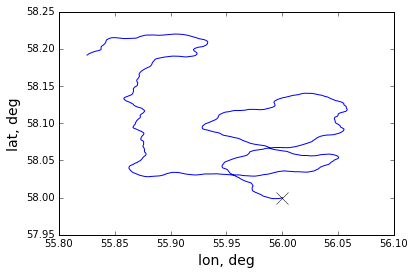

In [11]:
plt.plot(traj_ref.lon, traj_ref.lat)
plt.plot(traj_ref.lon[0], traj_ref.lat[0], 'kx', markersize=12)
plt.xlabel("lon, deg")
plt.ylabel("lat, deg")

## Integrating ideal data

Just to check that everything is correct we want to integrate the generated gyro and accel readings.

In [12]:
from pyins.integrate import coning_sculling, integrate
from pyins.filt import traj_diff

First we apply coning and sculling corrections:

In [13]:
theta, dv = coning_sculling(gyro, accel)

And the run the integration.

In [14]:
traj_ideal = integrate(dt, *traj_ref.iloc[0], theta, dv)

Compute integration error using a convenience function:

In [15]:
err_ideal = traj_diff(traj_ideal, traj_ref)

In [16]:
def plot_errors(dt, err, step=1000):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(331)
    err = err.iloc[::step]
    
    t = err.index * dt / 3600
    
    plt.plot(t, err.lat, label='lat')
    plt.xlabel("time, h")
    plt.ylabel("m")
    plt.legend(loc='best')
    
    plt.subplot(334)
    plt.plot(t, err.lon, label='lon')
    plt.xlabel("time, h")
    plt.ylabel("m")
    plt.legend(loc='best')
    
    plt.subplot(332)
    plt.plot(t, err.VE, label='VE')
    plt.xlabel("time, h")
    plt.ylabel("m/s")
    plt.legend(loc='best')
    
    plt.subplot(335)
    plt.plot(t, err.VN, label='VN')
    plt.xlabel("time, h")
    plt.ylabel("m/s")
    plt.legend(loc='best')

    plt.subplot(333)
    plt.plot(t, err.h, label='heading')
    plt.xlabel("time, h")
    plt.ylabel("deg")
    plt.legend(loc='best')
    
    plt.subplot(336)
    plt.plot(t, err.p, label='pitch')
    plt.xlabel("time, h")
    plt.ylabel("deg")
    plt.legend(loc='best')
    
    plt.subplot(339)
    plt.plot(t, err.r, label='roll')
    plt.xlabel("time, h")
    plt.ylabel("deg")
    plt.legend(loc='best')
    
    plt.tight_layout()

We see that attitude and velocity errors are vanishingly small. The position errors are less than 3 meters during 3 hours of operations, which is completely negligible compared to errors of even the most accurate INS.

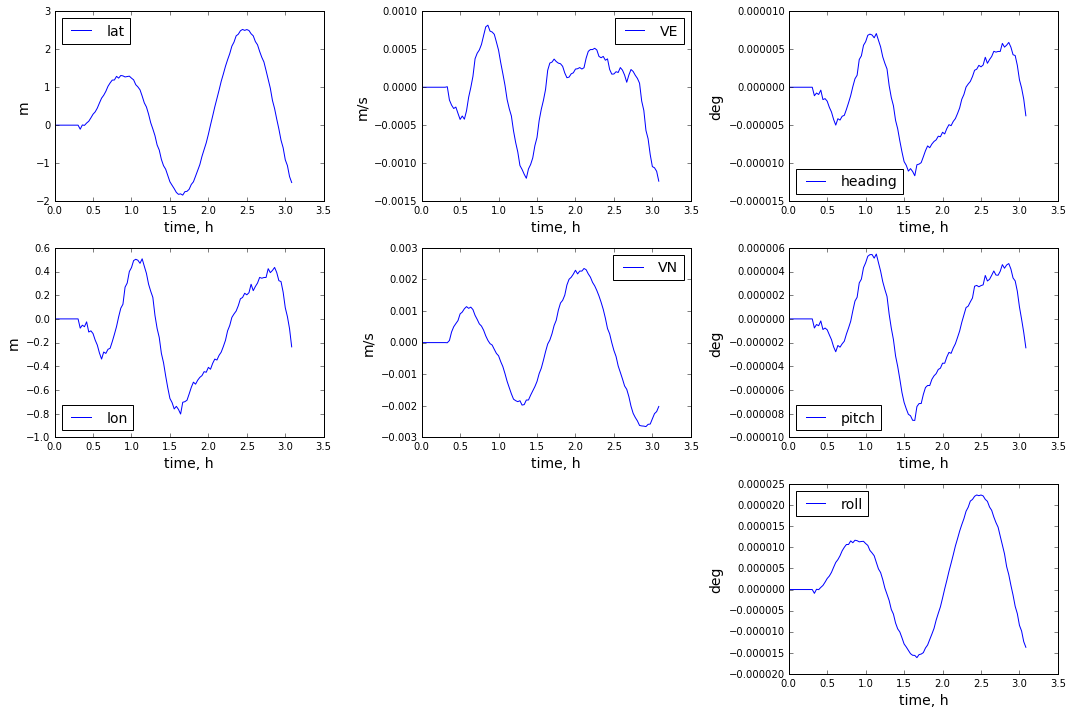

In [17]:
plot_errors(dt, err_ideal)

## Integrating "real" data

Now we will run the navigation using inertial sensors with errors.

The error will be a sum of a random bias and additive white noise. We define magnitudes typical for moderately accurate navigation grade sensors.

In [18]:
gyro_bias_sd = np.deg2rad(0.05) / 3600  # 0.05 d/h
accel_bias_sd = 5e-3

In [19]:
gyro_bias_sd

2.4240684055476802e-07

In [20]:
gyro_noise = 1e-6  # rad / s^0.5
accel_noise = 3e-4  # m / s^1.5

Compute biases as a random constants. To avoid a "bad case" in this example we generated biases uniformly within $[-2 \sigma, 2 \sigma]$.

In [21]:
np.random.seed(1)

In [22]:
gyro_bias = gyro_bias_sd * np.random.uniform(-2, 2, 3)
accel_bias = accel_bias_sd * np.random.uniform(-2, 2, 3)

In [23]:
gyro_bias, accel_bias

(array([ -8.04577347e-08,   2.13632657e-07,  -4.84702780e-07]),
 array([-0.00395335, -0.00706488, -0.00815323]))

In [24]:
from pyins import earth

Now we apply errors to inertial readings:

In [25]:
gyro_e = gyro + gyro_bias * dt + gyro_noise * np.random.randn(*gyro.shape) * dt**0.5
accel_e = accel + accel_bias * dt + accel_noise * np.random.randn(*accel.shape) * dt**0.5

Compute coning and sculling corrections:

In [26]:
theta, dv = coning_sculling(gyro_e, accel_e)

An INS operation have to start with the self alignment. We devote 15 minutes of the initial rest for it:

In [27]:
t_align = 15 * 60
align_samples = int(t_align / dt)

Split the readings into alignment and navigation parts:

In [28]:
theta_align = theta[:align_samples]
theta_nav = theta[align_samples:]
dv_align = dv[:align_samples]
dv_nav = dv[align_samples:]

In [29]:
from pyins.align import align_wahba

In [30]:
(h0, p0, r0), P_align = align_wahba(dt, theta_align, dv_align, 58)

Compare estimated attitude angles with the true angles.

In [31]:
h0 - traj_ref.h.loc[align_samples],  p0 - traj_ref.p.loc[align_samples], r0 - traj_ref.r.loc[align_samples]

(-0.40618917661190324, -0.042803741642216619, 0.0221964579443489)

Assume that the initial position is known with the accuracy typical to GPS receivers:

In [32]:
lat0, lon0 = perturb_ll(traj_ref.lat.loc[align_samples], traj_ref.lon.loc[align_samples],
                        10 * np.random.randn(1), 10 * np.random.randn(1))

Assume that it is known that the navigation starts at rest ans set initial velocities to 0:

In [33]:
VE0 = 0
VN0 = 0

Now we can run the integration:

In [34]:
traj_real = integrate(dt, lat0, lon0, VE0, VN0, h0, p0, r0, theta_nav, dv_nav, stamp=align_samples)

In [35]:
traj_error = traj_diff(traj_real, traj_ref)

We see that even with very accurate gyros pure INS performance is not that good.

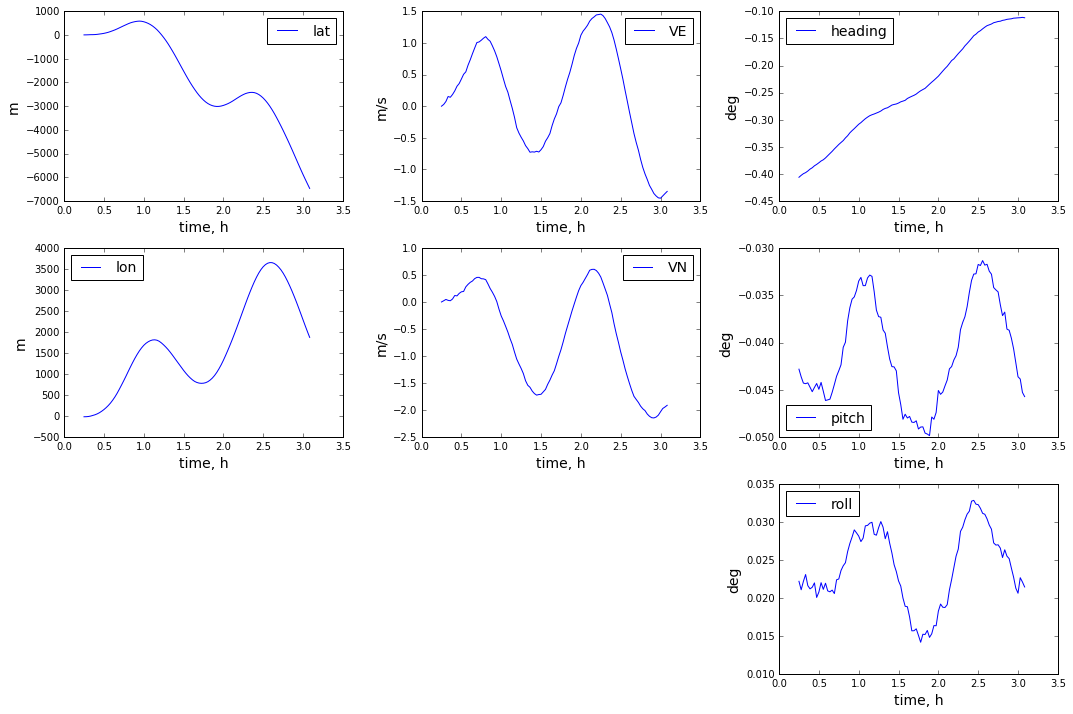

In [36]:
plot_errors(dt, traj_error)

## Aiding from GPS

Now we will use idealize GPS position observations for INS errors estimation and correction.

We assume that GPS is available every second and use known exact values of latitude and longitude:

In [37]:
gps_data = pd.DataFrame(index=traj_ref.index[::10])
gps_data['lat'] = traj_ref.lat[::10]
gps_data['lon'] = traj_ref.lon[::10]

We will use an idealized model that GPS observations contain only additive normal errors with a standard deviation of 10 meters (note that in reality errors in outputs from GPS receivers behave much worse).

In [38]:
gps_pos_sd = 10

In [39]:
gps_data['lat'], gps_data['lon'] = perturb_ll(gps_data.lat, gps_data.lon,
                                              gps_pos_sd * np.random.randn(*gps_data.lat.shape),
                                              gps_pos_sd * np.random.randn(*gps_data.lon.shape))

To use GPS measurements in a navigation Kalman filter we wrap this data into a special object:

In [40]:
from pyins.filt import LatLonObs

In [41]:
gps_obs = LatLonObs(gps_data, gps_pos_sd)

Also define gyro and accelerometer models using parameters defined above:

In [42]:
from pyins.filt import InertialSensor

In [43]:
gyro_model = InertialSensor(bias=gyro_bias_sd, noise=gyro_noise)
accel_model = InertialSensor(bias=accel_bias_sd, noise=accel_noise)

Now we can run a navigation Kalman filter which will blend INS and GPS data. In this example INS errors didn't grow very large, thus we can use a feedforward filter.

In [44]:
from pyins.filt import FeedforwardFilter

We create a filter by passing sampling period and computed trajectory. To initialize the covariance matrix we pass standard deviations of the initial errors.

Currently the covariance matrix is initialized as diagonal, even though it can be done more rigorously, i.e consider correlations between sensor biases and attitude errors. But my view is that a reliable filter should not depend on such fine details, otherwise it is likely to fail in real conditions. So for the sake of simplicity it is implemented like this for now (can be changed later).

Theoretical attitude accuracy (sd values) from static gyrocompassing in our case is: 0.35 deg for heading (`azimuth_sd`) and 0.03 deg for pitch and roll (`level_sd`). Here we set values slightly higher to account for a non-perfect alignment:

In [45]:
ff_filt = FeedforwardFilter(dt, traj_real,
                            pos_sd=10, vel_sd=0.1, azimuth_sd=0.5, level_sd=0.05,
                            gyro_model=gyro_model, accel_model=accel_model)

We run the filter and pass available measurements to it. The return value is the INS trajectory corrected by estimated errors.

In [46]:
ff_res = ff_filt.run(observations=[gps_obs])

Now we want to investigate errors in the filtered trajectory.

In [47]:
filt_error = traj_diff(ff_res.traj, traj_ref)

Obviously performance in terms of position and velocity accuracy is very good, but this is sort of expected because GPS provides coordinates directly. 

Attitude angle errors are generally decreasing as well, but the picture is less clear. We want to plot their standard deviation bounds estimated by the filter as well.

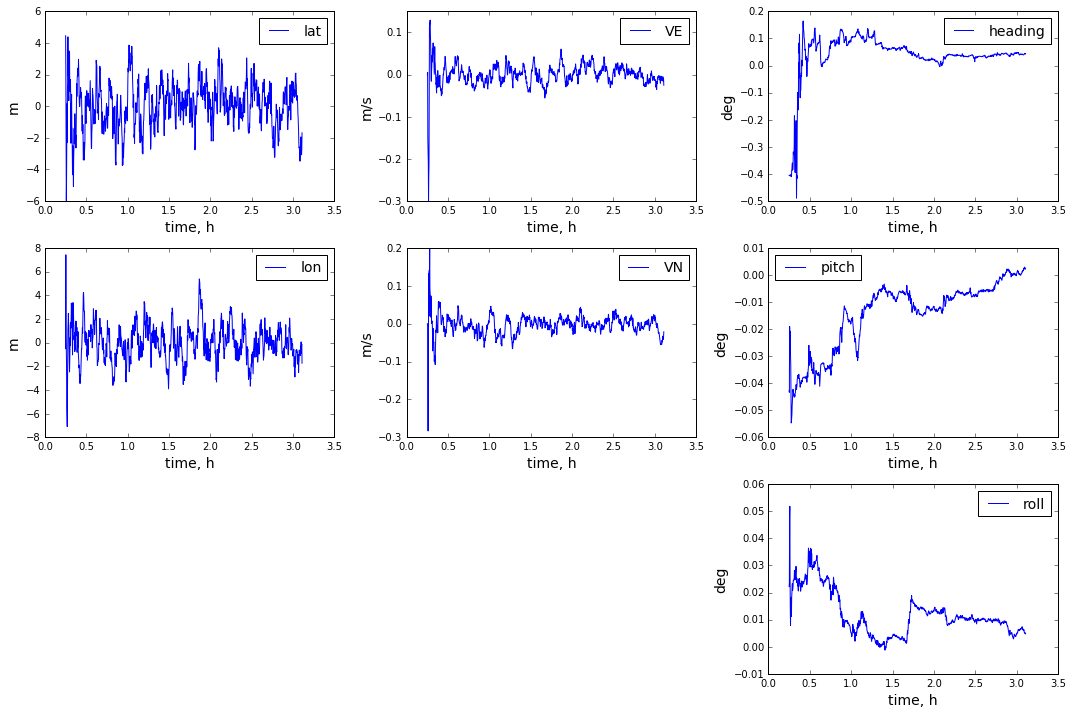

In [48]:
plot_errors(dt, filt_error, step=10)

The return value of `FeedforwardFilter` contains attributes `err`, `sd`, `gyro_err`, `gyro_sd`, `accel_err`, `accel_sd` for estimated trajectory errors and inertial sensor states and their standard deviations. Below we plot true errors for heading, pitch and roll with their 1-sigma bounds provided by the filter.

Generally we see that the filter's performance is adequate. It can be measured more precisely by Monte-Carlo simulation, but this will not be included in this example.

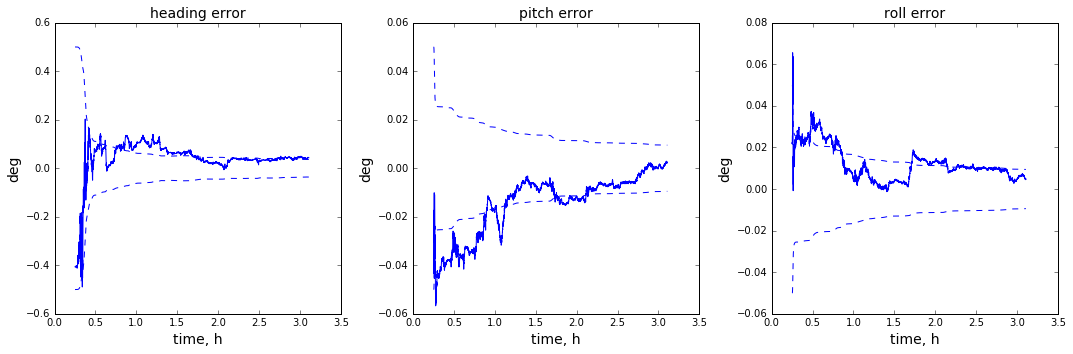

In [49]:
plt.figure(figsize=(15, 5))

t_plot = filt_error.index * dt / 3600

plt.subplot(131)
plt.plot(t_plot, filt_error.h, 'b')
plt.plot(t_plot, ff_res.sd.h, 'b--')
plt.plot(t_plot, -ff_res.sd.h, 'b--')
plt.xlabel("time, h")
plt.ylabel("deg")
plt.title("heading error")

plt.subplot(132)
plt.plot(t_plot, filt_error.p, 'b')
plt.plot(t_plot, ff_res.sd.p, 'b--')
plt.plot(t_plot, -ff_res.sd.p, 'b--')
plt.xlabel("time, h")
plt.ylabel("deg")
plt.title("pitch error")

plt.subplot(133)
plt.plot(t_plot,  filt_error.r, 'b')
plt.plot(t_plot, ff_res.sd.r, 'b--')
plt.plot(t_plot, -ff_res.sd.r, 'b--')
plt.xlabel("time, h")
plt.ylabel("deg")
plt.title("roll error")

plt.tight_layout()

Also it is interesting to assess the filter's sensor bias estimation. Plots below show $\pm \sigma$ bands of gyro bias estimates, the straight line depicts the true value. We see that estimation of gyro biases is quite successful.

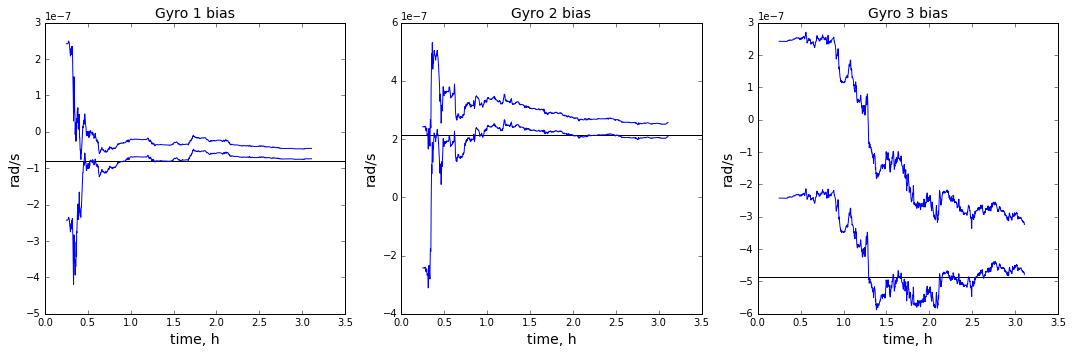

In [50]:
plt.figure(figsize=(15, 5))

t_plot = filt_error.index[::10] * dt / 3600

gyro_err = ff_res.gyro_err.iloc[::10]
gyro_sd = ff_res.gyro_sd.iloc[::10]

plt.subplot(131)
plt.plot(t_plot, gyro_err.BIAS_1 + gyro_sd.BIAS_1, 'b')
plt.plot(t_plot, gyro_err.BIAS_1 - gyro_sd.BIAS_1, 'b')
plt.hlines(gyro_bias[0], *plt.xlim())

plt.xlabel("time, h")
plt.ylabel("rad/s")
plt.title("Gyro 1 bias")

plt.subplot(132)
plt.plot(t_plot, gyro_err.BIAS_2 + gyro_sd.BIAS_2, 'b')
plt.plot(t_plot, gyro_err.BIAS_2 - gyro_sd.BIAS_2, 'b')
plt.hlines(gyro_bias[1], *plt.xlim())

plt.xlabel("time, h")
plt.ylabel("rad/s")
plt.title("Gyro 2 bias")

plt.subplot(133)
plt.plot(t_plot, gyro_err.BIAS_3 + gyro_sd.BIAS_3, 'b')
plt.plot(t_plot, gyro_err.BIAS_3 - gyro_sd.BIAS_3, 'b')
plt.hlines(gyro_bias[2], *plt.xlim())

plt.xlabel("time, h")
plt.ylabel("rad/s")
plt.title("Gyro 3 bias")

plt.tight_layout()

Below the same done for accelerometer biases. Horizontal accelerometer biases are less observable on the given trajectory than gyro biases, and the vertical bias is not observable at all because pitch and roll are held zero.

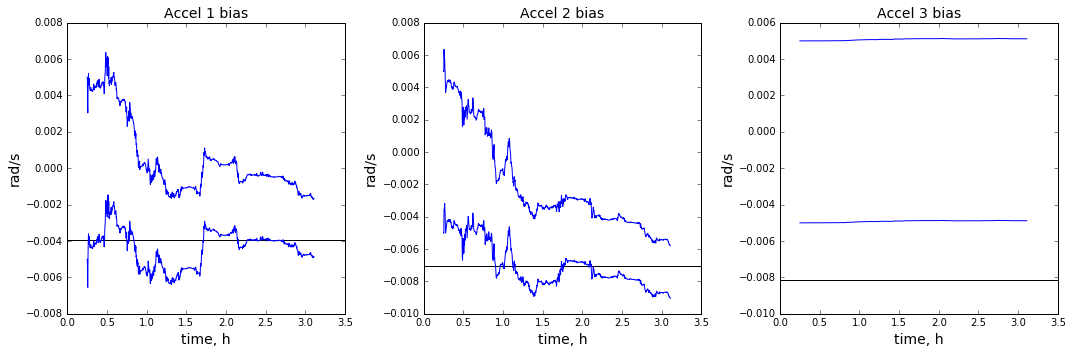

In [51]:
plt.figure(figsize=(15, 5))

t_plot = filt_error.index[::10] * dt / 3600

accel_err = ff_res.accel_err.iloc[::10]
accel_sd = ff_res.accel_sd.iloc[::10]

plt.subplot(131)
plt.plot(t_plot, accel_err.BIAS_1 + accel_sd.BIAS_1, 'b')
plt.plot(t_plot, accel_err.BIAS_1 - accel_sd.BIAS_1, 'b')
plt.hlines(accel_bias[0], *plt.xlim())

plt.xlabel("time, h")
plt.ylabel("rad/s")
plt.title("Accel 1 bias")

plt.subplot(132)
plt.plot(t_plot, accel_err.BIAS_2 + accel_sd.BIAS_2, 'b')
plt.plot(t_plot, accel_err.BIAS_2 - accel_sd.BIAS_2, 'b')
plt.hlines(accel_bias[1], *plt.xlim())

plt.xlabel("time, h")
plt.ylabel("rad/s")
plt.title("Accel 2 bias")

plt.subplot(133)
plt.plot(t_plot, accel_err.BIAS_3 + accel_sd.BIAS_3, 'b')
plt.plot(t_plot, accel_err.BIAS_3 - accel_sd.BIAS_3, 'b')
plt.hlines(accel_bias[2], *plt.xlim())

plt.xlabel("time, h")
plt.ylabel("rad/s")
plt.title("Accel 3 bias")

plt.tight_layout()